# Fix Match Algorithm 

. In this notebook, I implement the FixMatch algorithm on the CIFAR-10 dataset, a standard benchmark comprising 60,000 32×32 color images across 10 classes (airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks) 

. The FixMatch algorithm leverages limited labeled and abundant unlabeled data by generating pseudo-labels on weakly-augmented unlabeled images and enforcing consistency on strongly-augmented variants when the model is confident in its predictions 

. Through step-by-step code, I show dataset preparation, model definition, augmentation strategies, and training loops, highlighting how FixMatch bridges the gap between supervised and semi-supervised methods

### Imports

In [65]:
from keras.datasets import cifar10
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

### Data Loading

In [66]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

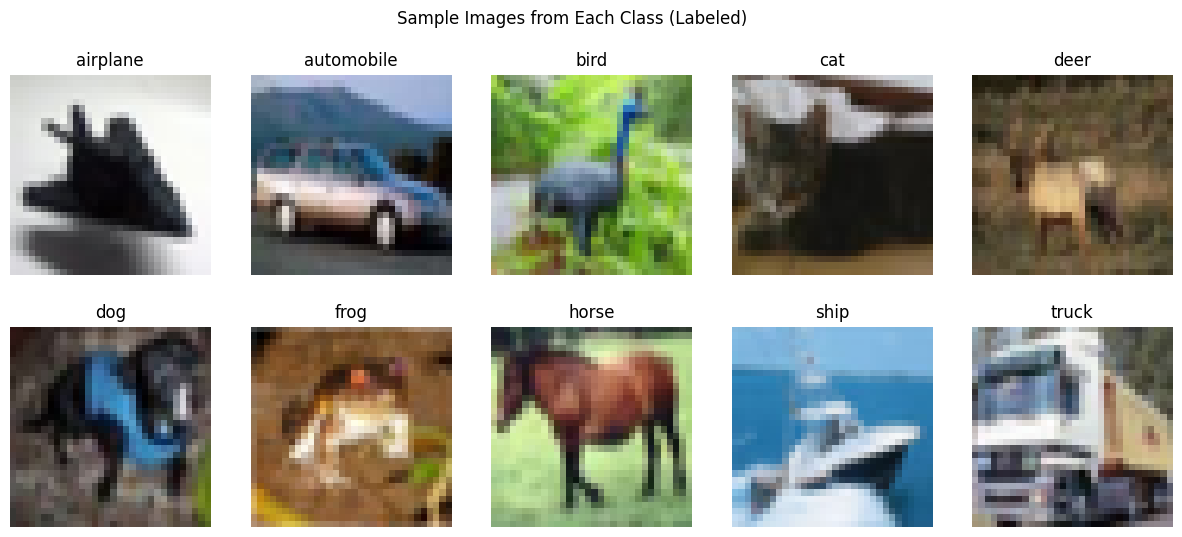

In [67]:
# CIFAR-10 class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.figure(figsize=(15,6))
for i in range(10):
    idx = np.where(y_train.flatten()==i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle("Sample Images from Each Class (Labeled)")
plt.show()

In [68]:
# Create an unlabeled dataset of the training set randomly
unlabel_ratio = 0.8
num_total = x_train.shape[0]
num_unlab = int(unlabel_ratio * num_total)
num_lab = num_total - num_unlab

indices = np.random.permutation(num_total)
unlab_indices = indices[:num_unlab]
lab_indices = indices[num_unlab:]

x_unlab = x_train[unlab_indices] / 255.0
y_unlab = y_train[unlab_indices]
x_train = x_train[lab_indices] / 255.0
y_train = y_train[lab_indices]

In [69]:
IMAGE_SIZE = 32
NUM_CLASSES = 10

In [70]:
shapes = {
    "x_train": x_train.shape,
    "y_train": y_train.shape,
    "x_unlab": x_unlab.shape,
    "y_unlab": y_unlab.shape,
    "x_test": x_test.shape,
    "y_test": y_test.shape
}
for name, shape in shapes.items():
    print(f"{name} shape: {shape}")

x_train shape: (10000, 32, 32, 3)
y_train shape: (10000, 1)
x_unlab shape: (40000, 32, 32, 3)
y_unlab shape: (40000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


### Supervised learning (baseline)

In [71]:
def create_model(image_size=IMAGE_SIZE):
  model = Sequential()
  # Add the layers
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

In [72]:
create_model().summary()

c:\Users\shiranga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,362 (2.37 MB)

 Trainable params: 620,362 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50

# Create the model
model = create_model()

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          shuffle=True)

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
157/157 [==============================] - 2s 10ms/step - loss: 1.9193 - accuracy: 0.2898 - val_loss: 197.3306 - val_accuracy: 0.3345
Epoch 2/50
157/157 [==============================] - 1s 8ms/step - loss: 1.5498 - accuracy: 0.4336 - val_loss: 260.4752 - val_accuracy: 0.3323
Epoch 3/50
157/157 [==============================] - 1s 8ms/step - loss: 1.3878 - accuracy: 0.4978 - val_loss: 249.9387 - val_accuracy: 0.3779
Epoch 4/50
157/157 [==============================] - 1s 8ms/step - loss: 1.2928 - accuracy: 0.5300 - val_loss: 298.4782 - val_accuracy: 0.3636
Epoch 5/50
157/157 [==============================] - 1s 6ms/step - loss: 1.2070 - accuracy: 0.5691 - val_loss: 243.4183 - val_accuracy: 0.4261
Epoch 6/50
157/157 [==============================] - 1s 8ms/step - loss: 1.0927 - accuracy: 0.6119 - val_loss: 267.5249 - val_accuracy: 0.4051
Epoch 7/50
157/157 [==============================] - 1s 8ms/step - loss: 1.0082 - accuracy: 0.6409 - val_loss: 268.8097 - val_accuracy

# FixMatch

In [14]:
# Define a function that weakly augments the images
def weak_augment(images):
  images = tf.image.random_flip_left_right(images)
  images = tf.image.random_brightness(images, max_delta=0.2)
  images = tf.image.random_contrast(images, lower=0.2, upper=1.8)
  return images

# Define a function that very strongly augments the images
def strong_augment(images):
  images = tf.image.random_flip_left_right(images)
  images = tf.image.random_brightness(images, max_delta=0.8)
  images = tf.image.random_contrast(images, lower=0.2, upper=1.8)
  images = tf.image.random_saturation(images, lower=0.2, upper=1.8)
  images = tf.image.random_hue(images, max_delta=0.2)
  return images

# Define a function that creates pseudo labels above a threshold of confidence and assign -1 to the others
def create_pseudo_labels(model, images, threshold):
  predictions = model(images, training=False)
  max_indexes = tf.math.argmax(predictions, axis=1)
  confidence = tf.reduce_max(predictions, axis=1)
  pseudo_labels = tf.where(confidence > threshold, max_indexes, -1)
  return pseudo_labels

### Test the augmentation

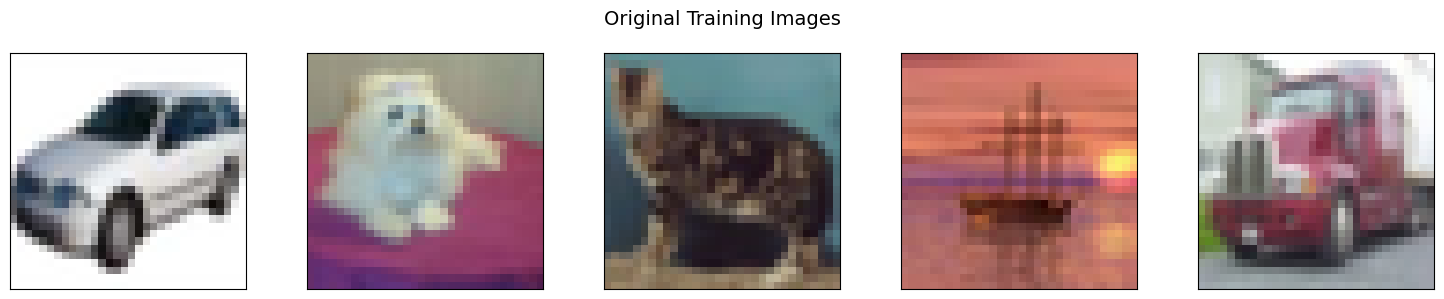

In [49]:
def plot_augmentation_comparison(images, num_images=10, augment_fn=None, title=None):
    """
    Plot original or augmented images in a grid.
    
    Args:
        images: Array of images to plot
        num_images: Number of images to display (default: 10)
        augment_fn: Augmentation function to apply (default: None)
        title: Title for the plot (default: None)
    """
    rows = int(np.ceil(num_images / 5))
    plt.figure(figsize=(15, 3*rows))
    
    for i in range(num_images):
        plt.subplot(rows, 5, i + 1)
        if augment_fn is not None:
            plt.imshow(augment_fn(images[i:i+1])[0])
        else:
            plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    
    if title:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize original images
plot_augmentation_comparison(x_train, num_images=5, 
                           title='Original Training Images')

### weakly augmented images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07659775018692017..1.1215894222259521].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22479850053787231..0.7948307394981384].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02480253577232361..0.8581543564796448].


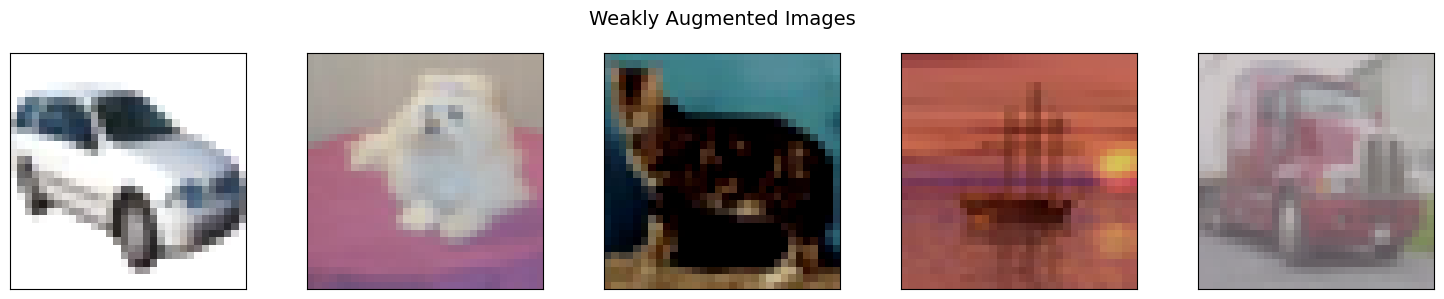

In [50]:
plot_augmentation_comparison(x_train, num_images=5,
                           augment_fn=weak_augment,
                           title='Weakly Augmented Images')

### strongly augmented images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2352309226989746..1.458351492881775].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16204199194908142..0.42436569929122925].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.44703176617622375..1.1015006303787231].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14940473437309265..1.1342273950576782].


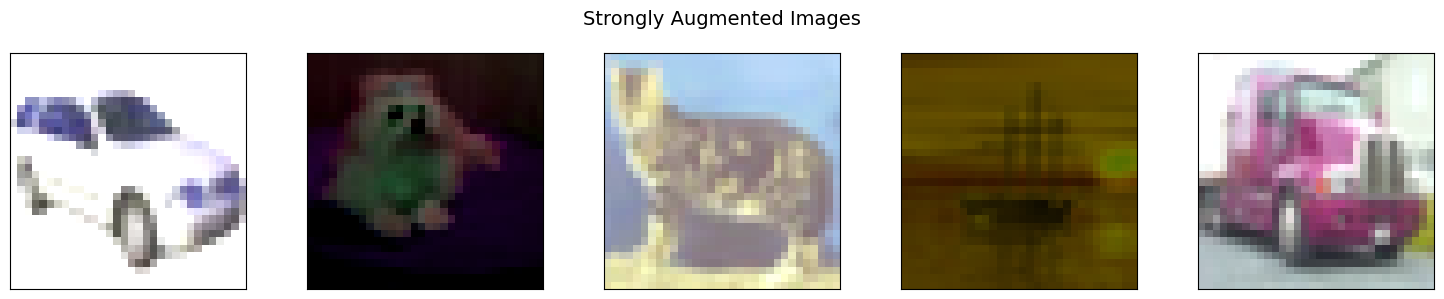

In [59]:
plot_augmentation_comparison(x_train, num_images=5,
                           augment_fn=strong_augment,
                           title='Strongly Augmented Images')

In [57]:
# Data
x_train_lab = x_train 
y_train_lab = y_train
x_train_unlab = x_unlab

# FixMatch Hyperparameters
mu = 7# size of unlab batch
lambda_u = 1 # loss weight
tau = 0.95 # weakly augmented threshold

# Training parameters
epochs = 500
lr = 1e-4
bs_lab = 32 # lab batch size
bs_unlab = mu * bs_lab # unlab batch size
bs_total = bs_lab + bs_unlab # total batch size
steps_per_epoch = math.floor(x_train_lab.shape[0]/bs_lab)
prev_acc = 0

# Logs
train_acc = []
test_acc = []
losses = []
losses_lab = []
losses_unlab = []
pseudo_lab = []

### Create Model

In [75]:
model = create_model(image_size=IMAGE_SIZE) 

# Training settings
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# metrics
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# indexes
indices_lab = np.arange(x_train_lab.shape[0]) # lab data
indices_unlab = np.arange(x_train_unlab.shape[0]) # unlab data

c:\Users\shiranga\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def get_batch(indices, data, labels, batch_size, step):
    """Get a batch of data and labels."""
    start_idx = step * batch_size
    end_idx = (step + 1) * batch_size
    batch_indices = indices[start_idx:end_idx]
    return data[batch_indices], labels[batch_indices] if labels is not None else None

def train_step(model, optimizer, x_lab, y_lab, x_unlab, loss_fn, tau, lambda_u):
    """Perform a single training step."""
    with tf.GradientTape() as tape:
        # Labeled data forward pass
        y_pred_lab = model(x_lab, training=True)
        loss_lab = loss_fn(y_lab, y_pred_lab)

        # Unlabeled data forward pass
        x_unlab_weak = weak_augment(x_unlab)
        x_unlab_strong = strong_augment(x_unlab)
        
        # Generate and filter pseudo-labels
        pseudo_labels = create_pseudo_labels(model, x_unlab_weak, tau)
        mask = pseudo_labels != -1
        
        loss_unlab = 0
        if tf.reduce_any(mask):
            y_pred_strong = model(x_unlab_strong, training=True)
            y_pseudo = tf.boolean_mask(pseudo_labels, mask)
            y_pred = tf.boolean_mask(y_pred_strong, mask)
            loss_unlab = loss_fn(y_pseudo, y_pred)
            
        # Total loss
        total_loss = loss_lab + lambda_u * loss_unlab
        
    # Optimization
    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return total_loss, loss_lab, loss_unlab, y_pred_lab, tf.reduce_sum(tf.cast(mask, tf.int32))

def evaluate_model(model, x_test, y_test, test_acc_metric):
    """Evaluate model on test data."""
    test_acc_metric.reset_states()
    y_test_pred = model(x_test, training=False)
    test_acc_metric.update_state(y_test, y_test_pred)
    return test_acc_metric.result().numpy()

### Training Loop

In [ ]:
for epoch in range(epochs):
    # Shuffle data
    np.random.shuffle(indices_lab)
    np.random.shuffle(indices_unlab)
    
    # Initialize metrics
    losses_epoch = {'total': 0., 'labeled': 0., 'unlabeled': 0.}
    num_pseudo_labels = 0
    train_acc_metric.reset_states()
    
    # Training loop
    for step in range(steps_per_epoch):
        # Get batches
        x_batch_lab, y_batch_lab = get_batch(indices_lab, x_train_lab, y_train_lab, bs_lab, step)
        x_batch_unlab, _ = get_batch(indices_unlab, x_train_unlab, None, bs_unlab, step)
        
        # Perform training step
        loss, loss_lab, loss_unlab, y_pred_lab, pseudo_count = train_step(
            model, optimizer, x_batch_lab, y_batch_lab, x_batch_unlab, 
            loss_fn, tau, lambda_u
        )
        
        # Update metrics
        losses_epoch['total'] += loss
        losses_epoch['labeled'] += loss_lab
        losses_epoch['unlabeled'] += loss_unlab
        num_pseudo_labels += pseudo_count
        train_acc_metric.update_state(y_batch_lab, y_pred_lab)
    
    # Calculate epoch metrics
    for k in losses_epoch:
        losses_epoch[k] /= steps_per_epoch
    num_pseudo_labels = int(num_pseudo_labels / steps_per_epoch)
    train_acc = train_acc_metric.result()
    test_acc = evaluate_model(model, x_test, y_test, test_acc_metric)
    
    # Save best model
    if test_acc > prev_acc:
        model.save_weights('model.h5')
        prev_acc = test_acc
        print('Model saved')
    
    # Log metrics
    losses.append(losses_epoch['total'])
    losses_lab.append(losses_epoch['labeled'])
    losses_unlab.append(losses_epoch['unlabeled'])
    train_acc.append(train_acc)
    test_acc.append(test_acc)
    pseudo_lab.append(num_pseudo_labels)
    
    print(f'Epoch: {epoch}, Loss: {losses_epoch["total"]:.4f}, '
          f'Loss lab: {losses_epoch["labeled"]:.4f}, '
          f'Loss unlab: {losses_epoch["unlabeled"]:.4f}, '
          f'Train Accuracy: {train_acc:.4f}, '
          f'Test Accuracy: {test_acc:.4f}, '
          f'Pseudo Labels: {num_pseudo_labels}')

Model saved
Epoch: 0, Loss: 2.0507259368896484, Loss lab: 2.0507259368896484, Loss unlab: 0.0, Train Accuracy: 0.24839743971824646, Test Accuracy: 0.3328999876976013, Pseudo Labels: 0
Model saved
Epoch: 1, Loss: 1.8847585916519165, Loss lab: 1.7951172590255737, Loss unlab: 0.08964121341705322, Train Accuracy: 0.3508613705635071, Test Accuracy: 0.3400999903678894, Pseudo Labels: 1
Model saved
Epoch: 2, Loss: 1.8274084329605103, Loss lab: 1.7172696590423584, Loss unlab: 0.1101389080286026, Train Accuracy: 0.38161057233810425, Test Accuracy: 0.3849000036716461, Pseudo Labels: 4
Model saved
Epoch: 3, Loss: 1.7560577392578125, Loss lab: 1.629141092300415, Loss unlab: 0.12691637873649597, Train Accuracy: 0.41266027092933655, Test Accuracy: 0.4203000068664551, Pseudo Labels: 2
Model saved
Epoch: 4, Loss: 1.6486788988113403, Loss lab: 1.5418188571929932, Loss unlab: 0.10686036944389343, Train Accuracy: 0.44340944290161133, Test Accuracy: 0.42399999499320984, Pseudo Labels: 3
Epoch: 5, Loss: 1.

In [ ]:
# Load the best model
model.load_weights('model.h5')

# Evaluate the model on the test data without using 'evaluate'
test_acc_metric.update_state(np.expand_dims(y_test,1), model(x_test, training=False))

# Calculate the average test accuracy
avg_test_acc = test_acc_metric.result().numpy()

# Print the results
print(f'Test Accuracy: {avg_test_acc}')

Test Accuracy: 0.6358000040054321


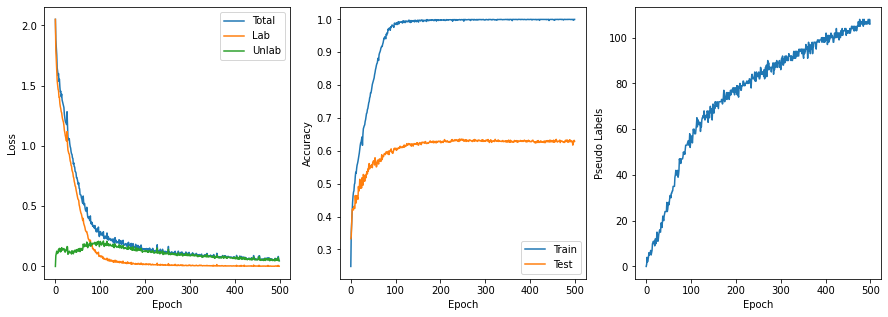

In [ ]:
# Plot the results (losses, accuracies, pseudo labels)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(losses, label='Total')
plt.plot(losses_lab, label='Lab')
plt.plot(losses_unlab, label='Unlab')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,3,2)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,3,3)
plt.plot(pseudo_lab)
plt.xlabel('Epoch')
plt.ylabel('Pseudo Labels')
plt.show()